# MFC Generative Modeling - Distribution Experiments

This notebook tests the Mean-Field Control (MFC) generative model for transporting various initial distributions to different target distributions.

### Experiments:
1. **Dirac -> Standard Gaussian** $\mathcal{N}(1, 1)$
2. **Dirac -> Student-t Distribution** (Heavy-tailed)
3. **Dirac -> Gaussian Mixture Model (GMM)** (Multi-modal)

**Note**: All plots are displayed inline and not saved to disk.


In [51]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Add source to path
sys.path.append(os.path.abspath("../"))

from src import Config, IterativeSolver, ExperimentManager
from src.score_matching import ScoreEstimator

# Set plotting style
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True

## 1. Define Custom Score Estimator for Non-Gaussian Targets

Override `ScoreEstimator` to accept a custom score function $\nabla \log \mu_T(x)$.

In [52]:
class GeneralScoreEstimator(ScoreEstimator):
    """
    Extended ScoreEstimator that supports arbitrary target distributions.
    """
    def __init__(self, target_score_fn, **kwargs):
        # Base init with dummy target stats (not used for score calc)
        super().__init__(target_mean=0.0, target_std=1.0, **kwargs)
        self.target_score_fn = target_score_fn

    def compute_terminal_gradient(
        self,
        x_terminal: torch.Tensor,
        y_clamp: float = 100.0,
        verbose: bool = True,
    ) -> torch.Tensor:
        """
        Y_N = λ * [-∇log μ_T(x) + ∇log ρ_N(x)]
        """
        # 1. Train ScoreNet (DSM)
        _ = self.train(x_terminal)
        
        # 2. Compute learned score ∇log ρ_N(x)
        generated_score = self.compute_score(x_terminal)
        
        # 3. Compute target term: -∇log μ_T(x)
        score_target = self.target_score_fn(x_terminal)
        target_term = -score_target
        
        # 4. Combine
        y_terminal = self.terminal_weight * (target_term + generated_score)
        y_terminal = torch.clamp(y_terminal, -y_clamp, y_clamp)
        
        return y_terminal

## 2. Define Distributions (Score & PDF)

In [53]:
# --- 1. Gaussian ---
def gaussian_score(x, mean=0.0, std=1.0):
    return -(x - mean) / (std ** 2)

def gaussian_pdf(x, mean=0.0, std=1.0):
    return stats.norm.pdf(x, loc=mean, scale=std)

# --- 2. Student-t ---
def student_t_score(x, df=2.0):
    # score = -(df+1)*x / (df + x^2)
    return -(df + 1) * x / (df + x**2)

def student_t_pdf(x, df=2.0):
    return stats.t.pdf(x, df=df)

# --- 3. Gaussian Mixture (GMM) ---
GMM_MEANS = [-2.0, 2.0]
GMM_STDS = [0.5, 0.5]
GMM_WEIGHTS = [0.5, 0.5]

def mix_gaussian_score(x, means=GMM_MEANS, stds=GMM_STDS, weights=GMM_WEIGHTS):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x)
    
    densities = []
    grads = []
    
    for mu, sigma, w in zip(means, stds, weights):
        sigma2 = sigma**2
        term = (x - mu) / sigma2
        density = w * torch.exp(-0.5 * (x - mu)**2 / sigma2) / (np.sqrt(2*np.pi)*sigma)
        densities.append(density)
        grads.append(density * (-term))
    
    total_density = sum(densities) + 1e-10
    total_grad = sum(grads)
    return total_grad / total_density

def mix_gaussian_pdf(x, means=GMM_MEANS, stds=GMM_STDS, weights=GMM_WEIGHTS):
    total_pdf = np.zeros_like(x)
    for mu, sigma, w in zip(means, stds, weights):
        total_pdf += w * stats.norm.pdf(x, loc=mu, scale=sigma)
    return total_pdf

## 3. Custom Visualization Function (Debug Optimized)

Added error handling and memory cleaning (`plt.close`). Images are NOT saved.

In [54]:
def plot_experiment_results(solver, target_pdf_fn, title_keyword):
    """
    Custom plotter for distribution experiments.
    Args:
        solver: Trained solver instance
        target_pdf_fn: Function x -> pdf(x) (numpy-compatible)
        title_keyword: Keyword for title/file naming (e.g., 'Student-t')
    """
    try:
        print(f"\n[Plotting] Generating visualizations for {title_keyword}...")
        # Simulat terminal distribution
        with torch.no_grad():
            trajectories, _ = solver.dynamics.simulate(
                solver.target_networks,
                batch_size=5000, 
                return_controls=False
            )
        
        # Handle dimensions: (T, N, D) -> (T, N)
        if trajectories.dim() == 3 and trajectories.shape[-1] == 1:
            trajectories = trajectories.squeeze(-1)
            
        trajectories_np = trajectories.cpu().numpy()
        terminal_particles = trajectories_np[-1, :]
        time_grid = solver.dynamics.time_grid.cpu().numpy()
        
        # --- Figure 1: Trajectories ---
        plt.figure(figsize=(10, 6))
        # Plot first 100 paths
        plt.plot(time_grid, trajectories_np[:, :100], alpha=0.1, color='blue')
        plt.plot(time_grid, trajectories_np.mean(axis=1), color='red', linewidth=2, label='Mean Path')
        plt.xlabel('Time')
        plt.ylabel('State X_t')
        plt.title(f'Trajectories: Dirac -> {title_keyword}')
        plt.legend()
        plt.show()
        plt.close() # Clean up
        
        # --- Figure 2: Terminal Distribution vs True Target ---
        plt.figure(figsize=(10, 6))
        
        # 1. Histogram of Generated Particles
        plt.hist(terminal_particles, bins=50, density=True, alpha=0.6, color='skyblue', label='Generated (MFC)')
        
        # 2. True Target PDF
        x_min, x_max = terminal_particles.min() - 1, terminal_particles.max() + 1
        x_grid = np.linspace(x_min, x_max, 500)
        true_pdf = target_pdf_fn(x_grid)
        plt.plot(x_grid, true_pdf, 'r--', linewidth=2, label=f'Target PDF ({title_keyword})')
        
        plt.title(f'Terminal Distribution Validation: {title_keyword}')
        plt.xlabel('State X_T')
        plt.ylabel('Density')
        plt.legend()
        plt.show()
        plt.close() # Clean up
        print("[Plotting] Success.")
        
    except Exception as e:
        print(f"\n[Plotting Error] Failed to plot: {e}")
        import traceback
        traceback.print_exc()

## 4. Experiment Runner

In [55]:
def run_experiment(name, target_score_fn, target_mean=0.0, target_std=1.0, iter_steps=100, lambda_val=2.0):
    print(f"\n=== Running Experiment: {name} ===")
    print(f"Settings: Iterations={iter_steps}, Lambda={lambda_val}")
    
    # 1. Configure
    try:
       config = Config.from_yaml("../config.yaml")
    except:
       config = Config() # Fallback
       
    # Override Training Params
    config.training.iterations = iter_steps
    config.training.terminal_weight = lambda_val
    config.training.tau = 0.5 

    # Override Target Params (Crucial for correct logging!)
    config.target.mean = target_mean
    config.target.std = target_std
    
    # --- DISABLE SAVING PLOTS ---
    config.experiment.save_plots = False
    config.experiment.name = f"exp_{name}"
    
    # 2. Init Solver
    exp_manager = ExperimentManager(config)
    solver = IterativeSolver(config, exp_manager, tau=config.training.tau)
    
    # 3. Inject Custom Estimator
    solver.score_estimator = GeneralScoreEstimator(
        target_score_fn=target_score_fn,
        device=solver.device,
        terminal_weight=config.training.terminal_weight,
        hidden_dim=config.model.hidden_dim
    )
    
    # 4. Train
    solver.run()
    return solver

## Experiment I: Gaussian $\mathcal{N}(1, 1)$


=== Running Experiment: Gaussian ===
Settings: Iterations=100, Lambda=2.0
📁 Experiment directory: experiments/2026-02-02_23-21-44_exp_Gaussian
Initialized solver on device: cpu
Number of networks: 50
Polyak averaging τ: 0.5
Total parameters (trainable): 428,850
Starting Iterative Backward Regression (Polyak Averaging)
Iterations: 100
Backward epochs per step: 100
Batch size: 2048
Polyak τ: 0.5
λ (terminal_weight): 2.0
Target: N(1.0, 1.0)
Iter [  1/100] | Loss: 0.003719 | μ=-0.023 (Δ=1.023), σ=1.014 (Δ=0.014)
Iter [  5/100] | Loss: 0.006726 | μ=0.601 (Δ=0.399), σ=1.228 (Δ=0.228)
Iter [ 10/100] | Loss: 0.000371 | μ=0.646 (Δ=0.354), σ=0.981 (Δ=0.019)
Iter [ 15/100] | Loss: 0.017721 | μ=0.514 (Δ=0.486), σ=0.822 (Δ=0.178)
Iter [ 20/100] | Loss: 0.003571 | μ=0.356 (Δ=0.644), σ=0.879 (Δ=0.121)
Iter [ 25/100] | Loss: 0.000190 | μ=0.669 (Δ=0.331), σ=0.962 (Δ=0.038)
Iter [ 30/100] | Loss: 0.008309 | μ=0.304 (Δ=0.696), σ=1.061 (Δ=0.061)
Iter [ 35/100] | Loss: 0.000157 | μ=0.699 (Δ=0.301), σ=1.03

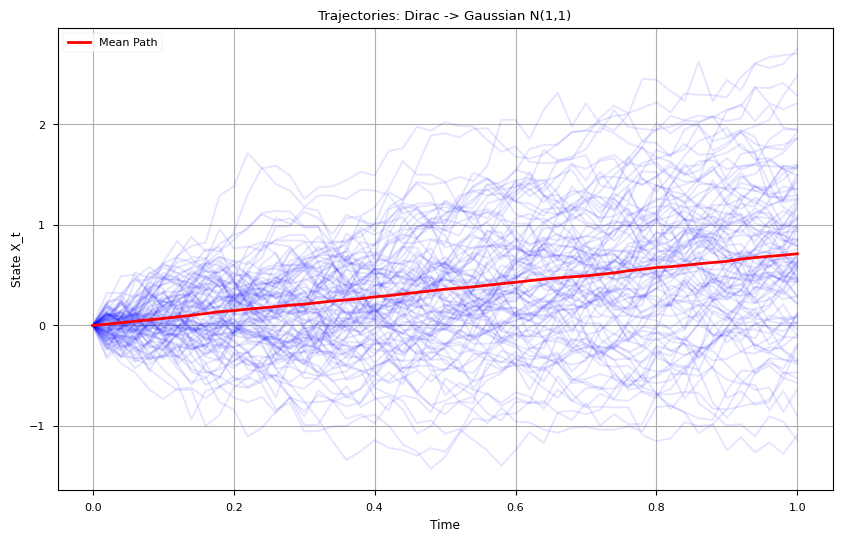

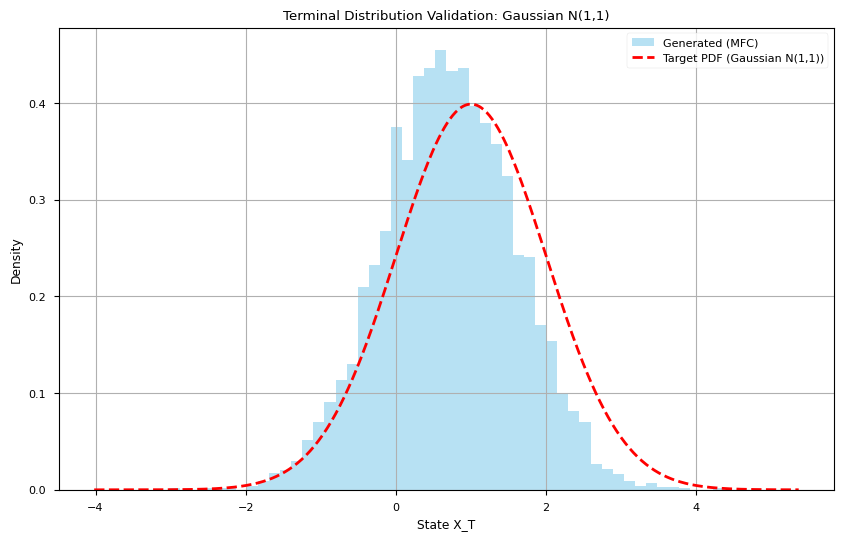

[Plotting] Success.


In [ ]:
# Run
solver_gauss = run_experiment(
    "Gaussian", 
    lambda x: gaussian_score(x, 1.0, 1.0),
    target_mean=1.0, # Just for logging
    target_std=1.0,# Just for logging
    iter_steps=200, 
    lambda_val=2.0
)

# Plot with correct PDF
plot_experiment_results(
    solver_gauss, 
    lambda x: gaussian_pdf(x, 1.0, 1.0), 
    "Gaussian N(1,1)"
)

## Experiment II: Student-t (df=2)


=== Running Experiment: Student_t ===
Settings: Iterations=100, Lambda=2.0
📁 Experiment directory: experiments/2026-02-02_23-33-25_exp_Student_t
Initialized solver on device: cpu
Number of networks: 50
Polyak averaging τ: 0.5
Total parameters (trainable): 428,850
Starting Iterative Backward Regression (Polyak Averaging)
Iterations: 100
Backward epochs per step: 100
Batch size: 2048
Polyak τ: 0.5
λ (terminal_weight): 2.0
Target: N(0.0, 1.0)
Iter [  1/100] | Loss: 0.011097 | μ=0.006 (Δ=0.006), σ=1.033 (Δ=0.033)
Iter [  5/100] | Loss: 0.001870 | μ=0.071 (Δ=0.071), σ=1.004 (Δ=0.004)
Iter [ 10/100] | Loss: 0.005305 | μ=-0.037 (Δ=0.037), σ=1.229 (Δ=0.229)
Iter [ 15/100] | Loss: 0.005637 | μ=0.088 (Δ=0.088), σ=1.159 (Δ=0.159)
Iter [ 20/100] | Loss: 0.009535 | μ=0.117 (Δ=0.117), σ=1.062 (Δ=0.062)
Iter [ 25/100] | Loss: 0.005747 | μ=-0.203 (Δ=0.203), σ=1.100 (Δ=0.100)
Iter [ 30/100] | Loss: 0.005291 | μ=0.072 (Δ=0.072), σ=1.315 (Δ=0.315)
Iter [ 35/100] | Loss: 0.004846 | μ=-0.139 (Δ=0.139), σ=

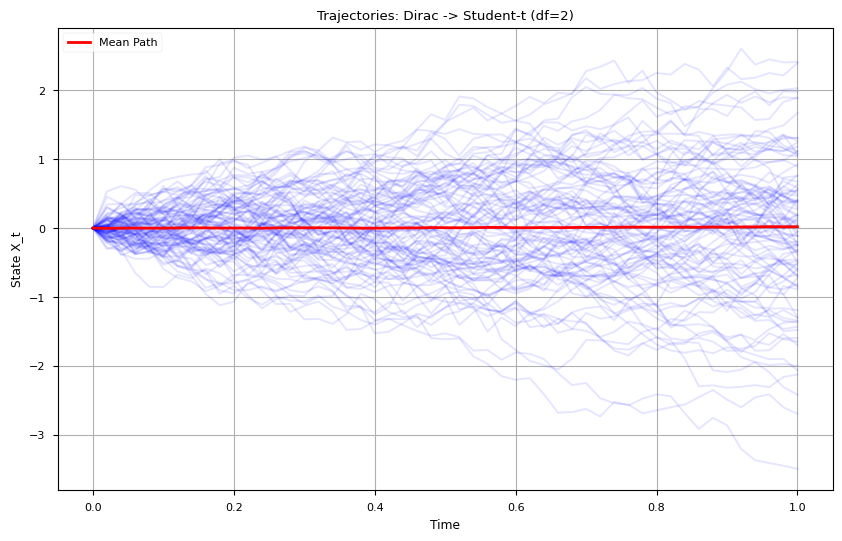

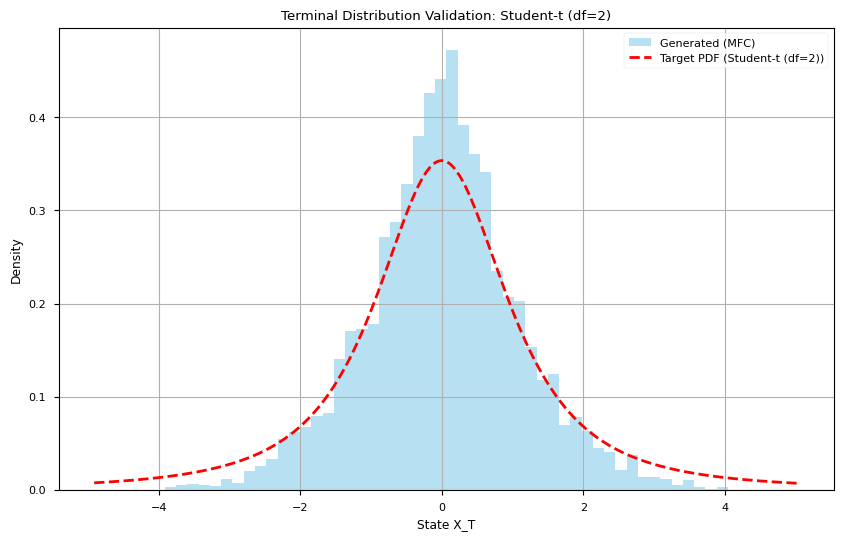

[Plotting] Success.


In [ ]:
# Run
solver_t = run_experiment(
    "Student_t", 
    lambda x: student_t_score(x, df=2.0),
    target_mean=0.0, 
    target_std=1.0, # Just for logging
    iter_steps=200, 
    lambda_val=2.0
)

# Plot with correct PDF
plot_experiment_results(
    solver_t, 
    lambda x: student_t_pdf(x, df=2.0), 
    "Student-t (df=2)"
)

## Experiment III: Gaussian Mixture (Bimodal)


=== Running Experiment: GMM ===
Settings: Iterations=100, Lambda=2.0
📁 Experiment directory: experiments/2026-02-02_23-44-11_exp_GMM
Initialized solver on device: cpu
Number of networks: 50
Polyak averaging τ: 0.5
Total parameters (trainable): 428,850
Starting Iterative Backward Regression (Polyak Averaging)
Iterations: 100
Backward epochs per step: 100
Batch size: 2048
Polyak τ: 0.5
λ (terminal_weight): 2.0
Target: N(0.0, 1.0)
Iter [  1/100] | Loss: 2.280614 | μ=0.044 (Δ=0.044), σ=1.033 (Δ=0.967)
Iter [  5/100] | Loss: 0.685559 | μ=-2.619 (Δ=2.619), σ=1.323 (Δ=0.677)
Iter [ 10/100] | Loss: 0.410864 | μ=-0.600 (Δ=0.600), σ=1.298 (Δ=0.702)
Iter [ 15/100] | Loss: 0.261844 | μ=-0.773 (Δ=0.773), σ=2.174 (Δ=0.174)
Iter [ 20/100] | Loss: 0.177760 | μ=-0.625 (Δ=0.625), σ=1.853 (Δ=0.147)
Iter [ 25/100] | Loss: 0.013551 | μ=-2.401 (Δ=2.401), σ=0.504 (Δ=1.496)
Iter [ 30/100] | Loss: 0.465245 | μ=-0.491 (Δ=0.491), σ=2.794 (Δ=0.794)
Iter [ 35/100] | Loss: 0.244266 | μ=-2.146 (Δ=2.146), σ=1.492 (Δ

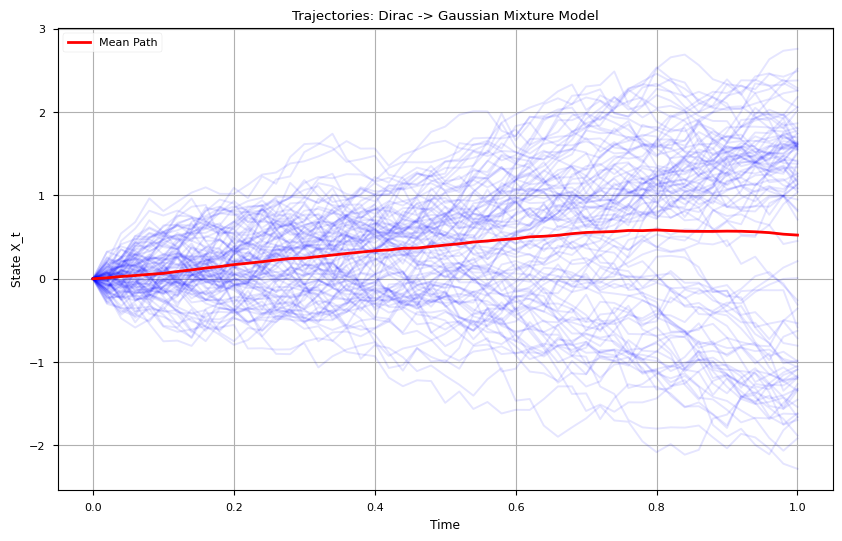

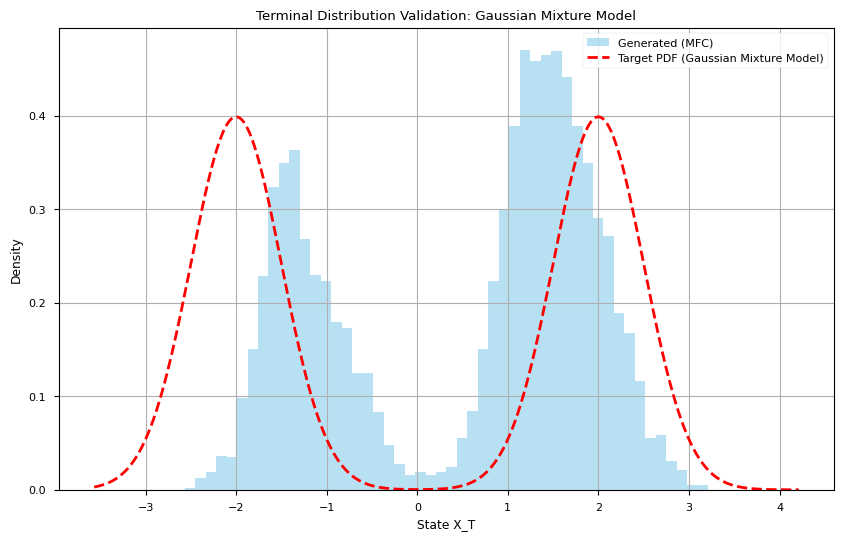

[Plotting] Success.


In [ ]:
# Run
solver_gmm = run_experiment(
    "GMM", 
    lambda x: mix_gaussian_score(x),
    target_mean=0.0, 
    target_std=2.0, # Prox approx std
    iter_steps=200, 
    lambda_val=2.0
)

# Plot with correct PDF
plot_experiment_results(
    solver_gmm, 
    lambda x: mix_gaussian_pdf(x), 
    "Gaussian Mixture Model"
)